## Importing all the necessary libraires 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
import warnings 
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import string
from tensorflow.keras.models import load_model

## Data exploration 

In [11]:
dfp = pd.read_excel("labeledposts.xlsx")

In [12]:
dfp.head(10)

,Unnamed: 0,post_id,subreddit,title,upvote_ratio,score,created_date,category
0,1,18dk3t6,Palestine,scoop egypt warned israel rupture relation pal...,0.85,5,2023-12-08 10:37:26,P_D
1,3,18dit8x,Palestine,aryeh king deputy mayor jerusalem israeli muni...,0.97,30,2023-12-08 09:00:33,P_D
2,4,18dirx9,Palestine,question within test written refaat al areer s...,0.94,16,2023-12-08 08:57:40,M_PO
3,5,18diquq,Palestine,gaza writes back famous book written refaat al...,0.93,36,2023-12-08 08:55:14,V_HC
4,9,18dgisj,Palestine,family israeli hostage rage netanyahu leaked a...,0.95,18,2023-12-08 06:19:07,P_D
5,10,18dfw10,Palestine,american funded israeli bomb break child skull...,0.96,331,2023-12-08 05:39:59,V_HC
6,13,18ddbo2,Palestine,palestinian child agonizing pain bomb particle...,0.96,307,2023-12-08 03:17:26,P_D
7,17,18dbp70,Palestine,message received reefat death,0.97,258,2023-12-08 01:52:36,M_PO
8,21,18darl3,Palestine,son israeli war cabinet minister killed northe...,0.90,43,2023-12-08 01:04:34,P_D
9,22,18da9ug,Palestine,twitter blocking community note user write not...,0.89,15,2023-12-08 00:39:59,M_PO


In [13]:
dfp.shape

(2165, 8)

In [14]:
dfp.columns

Index(['Unnamed: 0', 'post_id', 'subreddit', 'title', 'upvote_ratio', 'score',
       'created_date', 'category'],
      dtype='object')

In [15]:
dfp = dfp.drop(["Unnamed: 0"] , axis=1)

In [16]:
dfp.drop_duplicates(subset='title', keep='first', inplace=True)

In [17]:
dfp.shape

(2156, 7)

In [18]:
print(dfp.isnull().sum())

post_id         0
subreddit       0
title           0
upvote_ratio    0
score           0
created_date    0
category        0
dtype: int64


In [19]:
print("Total subreddits : \n " , dfp.subreddit.unique())

Total subreddits : 
  ['Palestine' 'IsraelPalestine' 'IsrealPalestineWar_23' 'worldnews'
 'AskMiddleEast']


In [20]:
print("Categories : " , dfp.category.unique())
print(dfp.category.value_counts())

Categories :  ['P_D' 'M_PO' 'V_HC']
V_HC    885
P_D     694
M_PO    577
Name: category, dtype: int64


# EDA, Metafeatures & Viz

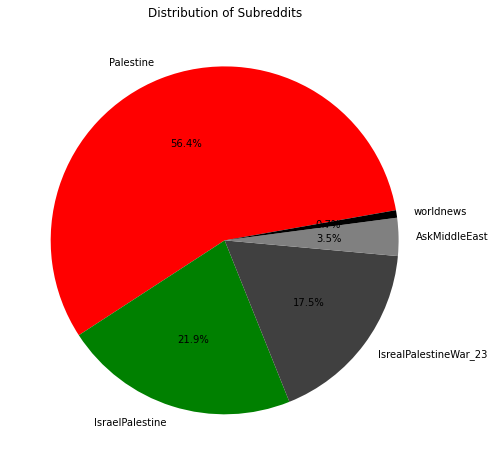

In [21]:
subreddits  = dfp.subreddit.value_counts()

# Extract labels and values for the pie chart
labels = subreddits.index
values = subreddits.values

# Define colors for each slice
colors = ['red', 'green', '#404040', 'grey' , 'black']
# Set a larger figsize
plt.figure(figsize=(12, 8))
# Create a pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=10, colors=colors, textprops={'color': 'black'})

# Add a title
plt.title('Distribution of Subreddits')

# Show the plot
plt.show()

In [22]:
class_dfp = dfp.groupby('category').count()['title'].reset_index().sort_values(by='title',ascending=False)
class_dfp.style.background_gradient(cmap='hot')

,category,title
2,V_HC,885
1,P_D,694
0,M_PO,577


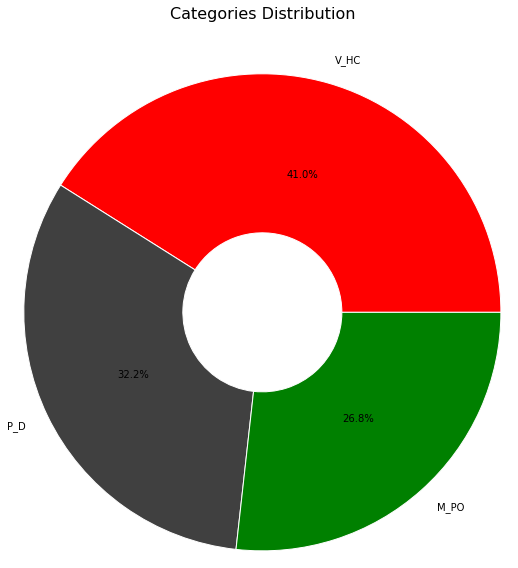

In [23]:
percent_class = class_dfp.title
labels = class_dfp.category
colors = ['red', '#404040', 'green']

fig, ax = plt.subplots(figsize=(12, 8))

fig.suptitle("Categories Distribution", fontsize=16)

my_pie, _, _ = ax.pie(percent_class, radius=1.2, labels=labels, textprops={'color': 'black'}, colors=colors, autopct="%.1f%%")

fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.setp(my_pie, width=0.8, edgecolor='white')

plt.show()


### there is an uneven distribution of classes with V_HC taking the largest part of the pie , this might be causing problems 

#### V_HC = Violence/ humanitarian crisis 
#### M_PO = Media/public opinion
#### P_D = politics/ diplomacy
     

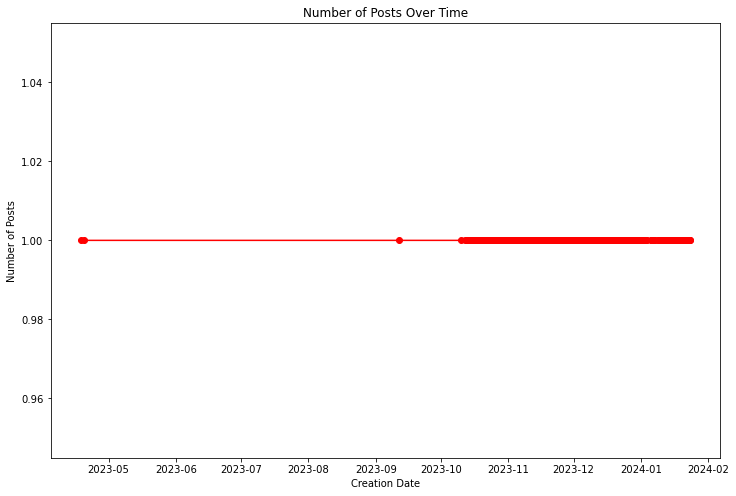

In [25]:
# Convert 'creation_date' to datetime if it's not already in datetime format
dfp['created_date'] = pd.to_datetime(dfp['created_date'])
# Group by creation date and count the occurrences
date_counts = dfp['created_date'].value_counts().sort_index()

# Create a line plot
plt.figure(figsize=(12, 8))
plt.plot(date_counts.index, date_counts.values, marker='o', linestyle='-', color='red')
plt.title('Number of Posts Over Time')
plt.xlabel('Creation Date')
plt.ylabel('Number of Posts')
plt.show()

In [26]:
def length(text):
    return len(text)
dfp['length'] = dfp['title'].apply(length)
dfp['words']= dfp['title'].str.split().map(lambda x : len(x))

In [27]:
dfp.head()

,post_id,subreddit,title,upvote_ratio,score,created_date,category,length,words
0,18dk3t6,Palestine,scoop egypt warned israel rupture relation pal...,0.85,5,2023-12-08 10:37:26,P_D,65,9
1,18dit8x,Palestine,aryeh king deputy mayor jerusalem israeli muni...,0.97,30,2023-12-08 09:00:33,P_D,169,22
2,18dirx9,Palestine,question within test written refaat al areer s...,0.94,16,2023-12-08 08:57:40,M_PO,171,25
3,18diquq,Palestine,gaza writes back famous book written refaat al...,0.93,36,2023-12-08 08:55:14,V_HC,155,22
4,18dgisj,Palestine,family israeli hostage rage netanyahu leaked a...,0.95,18,2023-12-08 06:19:07,P_D,50,7


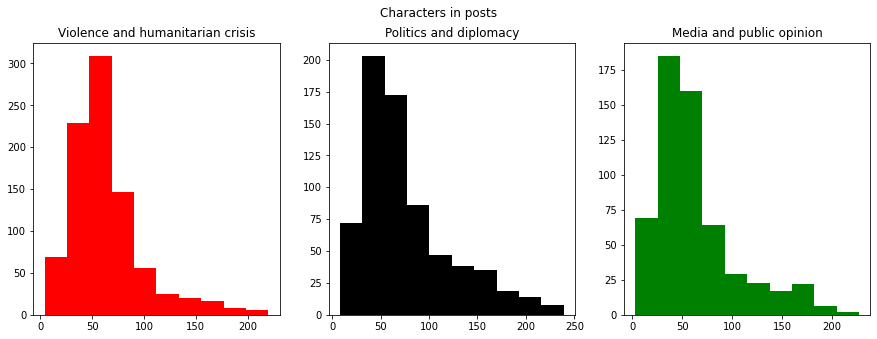

In [28]:
#numbers of characters
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

post_len=dfp[dfp['category']=="V_HC"]['length']
ax1.hist(post_len,color='red')
ax1.set_title('Violence and humanitarian crisis')

post_len=dfp[dfp['category']=="P_D"]['length']
ax2.hist(post_len,color='black')
ax2.set_title('Politics and diplomacy')

post_len=dfp[dfp['category']=="M_PO"]['length']
ax3.hist(post_len,color='green')
ax3.set_title('Media and public opinion')

fig.suptitle('Characters in posts')
plt.show()

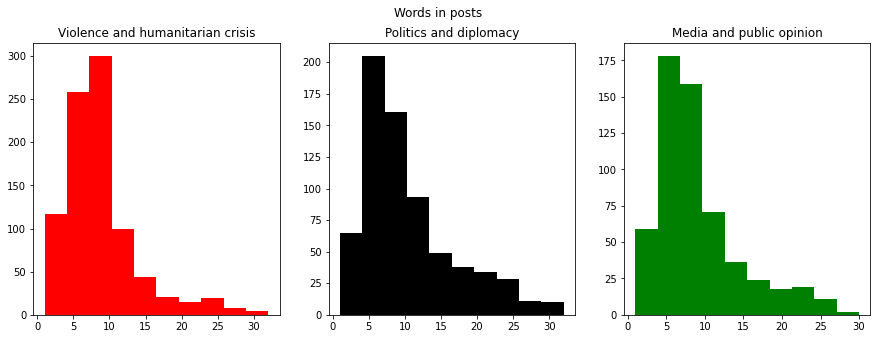

In [20]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

post_len=dfp[dfp['category']=="V_HC"]['words']
ax1.hist(post_len,color='red')
ax1.set_title('Violence and humanitarian crisis')

post_len=dfp[dfp['category']=="P_D"]['words']
ax2.hist(post_len,color='black')
ax2.set_title('Politics and diplomacy')

post_len=dfp[dfp['category']=="M_PO"]['words']
ax3.hist(post_len,color='green')
ax3.set_title('Media and public opinion')

fig.suptitle('Words in posts')


plt.show()

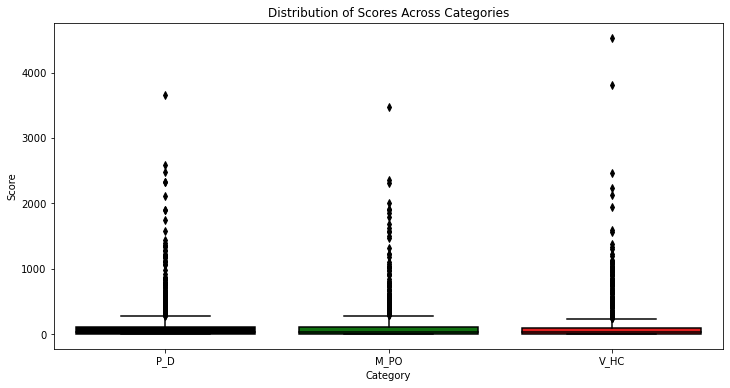

In [29]:
plt.figure(figsize=(12, 6))
colors = [ "black", "green" , "red"]
sns.boxplot(x='category', y='score', data=dfp, palette= colors )
plt.title('Distribution of Scores Across Categories')
plt.xlabel('Category')
plt.ylabel('Score')
plt.show()

In [30]:
l = {"M_PO" : 0 , "P_D" : 1 , "V_HC" : 2} 

In [31]:
dfp["category"] = dfp['category'].map(l)

In [32]:
dfp.head()

,post_id,subreddit,title,upvote_ratio,score,created_date,category,length,words
0,18dk3t6,Palestine,scoop egypt warned israel rupture relation pal...,0.85,5,2023-12-08 10:37:26,1,65,9
1,18dit8x,Palestine,aryeh king deputy mayor jerusalem israeli muni...,0.97,30,2023-12-08 09:00:33,1,169,22
2,18dirx9,Palestine,question within test written refaat al areer s...,0.94,16,2023-12-08 08:57:40,0,171,25
3,18diquq,Palestine,gaza writes back famous book written refaat al...,0.93,36,2023-12-08 08:55:14,2,155,22
4,18dgisj,Palestine,family israeli hostage rage netanyahu leaked a...,0.95,18,2023-12-08 06:19:07,1,50,7


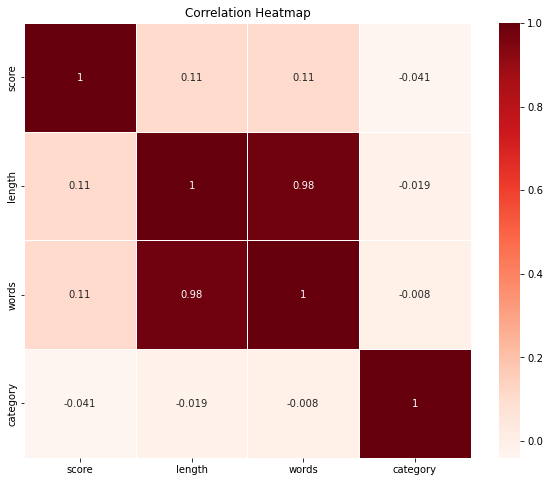

In [33]:
# Select the columns of interest
selected_columns = ['score', 'length', 'words', 'category']
selected_df = dfp[selected_columns]

# Compute the correlation matrix
correlation_matrix = selected_df.corr()

# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

### Since the correlation between the features and the target variables  is low , we're going to keep the title only 

In [34]:
dfp1 = dfp[["title", "category"]]
dfp1.head()


,title,category
0,scoop egypt warned israel rupture relation pal...,1
1,aryeh king deputy mayor jerusalem israeli muni...,1
2,question within test written refaat al areer s...,0
3,gaza writes back famous book written refaat al...,2
4,family israeli hostage rage netanyahu leaked a...,1


## Text  Processing 

#### Stop words , punctuation and urls are already removed , when labeling part of the data , as well as making words in lower case 

In [35]:
#tokenize words , and familiriaze with them 
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
all_titles = dfp1['title'].str.cat(sep=' ')
corpus_words = word_tokenize(all_titles)
corpus_freqdist = FreqDist(corpus_words)

In [36]:
len(corpus_freqdist.keys())

4802

In [37]:
print("Vocabulary dictionary : ")
# Sort the dictionary by values in descending order
sorted_freq_dist = dict(sorted(corpus_freqdist.items(), key=lambda item: item[1], reverse=True))

for word, frequency in sorted_freq_dist.items():
    print(f"{word}: {frequency }")

Vocabulary dictionary : 
israel: 550
gaza: 544
israeli: 425
palestinian: 339
hamas: 221
genocide: 212
hostage: 160
war: 149
palestine: 146
US: 142
hospital: 109
attack: 106
people: 99
child: 91
idf: 89
killed: 85
journalist: 83
say: 76
soldier: 76
support: 74
civilian: 72
death: 70
home: 68
state: 67
new: 64
international: 62
video: 62
netanyahu: 61
west: 60
footage: 60
day: 57
bombing: 57
killing: 57
one: 56
family: 54
biden: 53
bomb: 52
government: 51
conflict: 50
bank: 50
ceasefire: 50
right: 49
south: 49
un: 48
propaganda: 48
kill: 47
call: 47
al: 46
military: 46
post: 45
opinion: 44
crime: 44
world: 43
us: 43
aid: 42
released: 42
year: 41
news: 41
woman: 41
zionist: 41
release: 41
force: 40
leader: 40
amp: 40
refugee: 40
stop: 38
iof: 37
settler: 37
show: 37
american: 36
school: 36
time: 36
claim: 35
uk: 35
case: 34
message: 33
humanitarian: 33
medium: 33
shot: 33
resistance: 33
dead: 33
october: 33
want: 33
strip: 32
president: 32
prisoner: 32
minister: 31
think: 31
interview: 31

honest: 3
broker: 3
removal: 3
shame: 3
series: 3
pressure: 3
genuine: 3
native: 3
able: 3
education: 3
witnessed: 3
rise: 3
irish: 3
subreddit: 3
cyprus: 3
together: 3
fanatic: 3
syria: 3
else: 3
etc: 3
coming: 3
removed: 3
legitimate: 3
late: 3
modern: 3
original: 3
diplomacy: 3
survey: 3
til: 3
easily: 3
regional: 3
democrat: 3
operative: 3
fun: 3
teen: 3
domestic: 3
created: 3
cost: 3
unarmed: 3
catastrophe: 3
absolute: 3
genuinely: 3
defending: 3
morgan: 3
detainee: 3
activity: 3
detained: 3
kibbutz: 3
receives: 3
asked: 3
multiple: 3
excuse: 3
soul: 3
halt: 3
hide: 3
saudi: 3
strong: 3
kind: 3
wo: 3
cemetery: 3
prevented: 3
blame: 3
perfect: 3
inhuman: 3
mosque: 3
witness: 3
alongside: 3
dr: 3
exposing: 3
france: 3
corridor: 3
myth: 3
throughout: 3
shapiro: 3
whats: 3
wonderful: 3
allah: 3
abbas: 3
perspective: 3
agree: 3
heavily: 3
stay: 3
leading: 3
c: 3
sure: 3
warplane: 3
caused: 3
tension: 3
escalating: 3
covering: 3
seeking: 3
search: 3
running: 3
impact: 3
link: 3
mia: 3
c

diya: 1
kahlot: 1
diaa: 1
dia: 1
kahlout: 1
subjecting: 1
credible: 1
belgium: 1
entry: 1
bos: 1
prompting: 1
mandate: 1
hansard: 1
dutch: 1
stephan: 1
baarle: 1
inclusive: 1
briton: 1
luton: 1
aditya: 1
chakrabortty: 1
rapper: 1
nowthis: 1
presidency: 1
accurate: 1
yanis: 1
summoned: 1
choir: 1
associate: 1
agriculture: 1
pretext: 1
flooding: 1
shift: 1
rightful: 1
blast: 1
donated: 1
assuming: 1
wonder: 1
profitable: 1
confronts: 1
highest: 1
disposal: 1
maintenance: 1
misery: 1
trap: 1
mahmoud: 1
qaddoha: 1
traumatized: 1
terribly: 1
heated: 1
fury: 1
swing: 1
slims: 1
arizona: 1
pennsylvania: 1
pledged: 1
withdraw: 1
citing: 1
friendly: 1
strongest: 1
undermining: 1
fatigue: 1
objectivity: 1
fan: 1
moroccan: 1
celebrate: 1
harvested: 1
sloppy: 1
stunned: 1
transfer: 1
revive: 1
jointly: 1
conspired: 1
feminist: 1
gothenburg: 1
recites: 1
apocalyptic: 1
resumed: 1
focusing: 1
tide: 1
disgust: 1
intensifying: 1
rich: 1
diverse: 1
honor: 1
uplift: 1
indigenousculture: 1
diversitymatte

warship: 1
expl: 1
delicate: 1
balancing: 1
closer: 1
multifaceted: 1
conf: 1
palestinían: 1
gazâ: 1
certainly: 1
shocked: 1
shabbat: 1
dinner: 1
seat: 1
addressing: 1
incr: 1
tilt: 1
player: 1
relief: 1
parroting: 1
amazement: 1
speechless: 1
affecting: 1
israelgazawar: 1
palestinegenocide: 1
gazagenocide: 1
visuals: 1
outrage: 1
telegram: 1
toke: 1
square: 1
escalates: 1
steel: 1
pipe: 1
threatens: 1
established: 1
brotherhood: 1
israelpale: 1
punishment: 1
employed: 1
pleads: 1
ho: 1
israelpal: 1
unseen: 1
compilation: 1
deadline: 1
unfolds: 1
israelpa: 1
escalate: 1
unjustifiable: 1
hierarchy: 1
asymmetrical: 1
fuck: 1
putin: 1
caution: 1
unacceptable: 1
civillians: 1
implicated: 1
sided: 1
upvotes: 1
station: 1
bab: 1
gadar: 1
spike: 1
naval: 1
sderot: 1
blatant: 1
warsaw: 1
apologizes: 1
meta: 1
criticising: 1
india: 1
qin: 1
gang: 1
hacker: 1
hack: 1
telecommunication: 1
thirty: 1
represents: 1
bloodiest: 1
malaysian: 1
mem: 1
cornel: 1
honorable: 1
observed: 1
educate: 1
geoblo

swiss: 1
forum: 1
actionists: 1
raised: 1
recruitment: 1
brough: 1
recruit: 1
component: 1
emmaline: 1
blake: 1
paint: 1
photograph: 1
poignant: 1
portrays: 1
cradling: 1
worst: 1
expensive: 1
pizza: 1
dismissal: 1
australia: 1
lobbyist: 1
orchestrating: 1
termination: 1
tolerate: 1
ounce: 1
influential: 1
behavior: 1
shireen: 1
aqleh: 1
instance: 1
continuously: 1
updated: 1
nurit: 1
portrayal: 1
text: 1
advisor: 1
wished: 1
insists: 1
noor: 1
harazeen: 1
evacuating: 1
suposedly: 1
msm: 1
spector: 1
hbo: 1
gilded: 1
harriet: 1
walter: 1
succession: 1
gbenga: 1
akinnagbe: 1
wire: 1
dossier: 1
alleging: 1
luther: 1
jr: 1
holiday: 1
propagandise: 1
requested: 1
architecture: 1
exhuming: 1
determine: 1
blesses: 1
ephraim: 1
mirvis: 1
magically: 1
transform: 1
miscalculation: 1
misguided: 1
hesitate: 1
greater: 1
lebron: 1
basketball: 1
jackson: 1
frank: 1
receiving: 1
nba: 1
compensation: 1
sentence: 1
deprived: 1
grapple: 1
inflicted: 1
plea: 1
capable: 1
airdrop: 1
tarik: 1
cyril: 1
ama

# Models

## Splitting and vectorizing the  data  

In [38]:
X = dfp1['title']
y = dfp1['category']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Vectorize the text data using TF-IDF
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

In [39]:
#min_df = 2 , ignore all the words which their tf < 2
# We transform each complaint into a vector
features = tfidf.fit_transform(dfp1.title).toarray()

labels = dfp1.category

print("Each of the %d titles is represented by %d features )" %(features.shape))

Each of the 2156 titles is represented by 3273 features )


In [40]:
# Dictionary mapping category names to category IDs
N= 3
category_to_id = {0: 'Media and public opinion', 1: 'Politics and Diplomacy', 2: 'Violence and humanitarian crisis'}

for category_id, category in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

    print("\n==> %s:" % (category))
    print("  * Most Correlated Unigrams are: %s" % (', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" % (', '.join(bigrams[-N:])))


==> Media and public opinion:
  * Most Correlated Unigrams are: opinion, footage, journalist
  * Most Correlated Bigrams are: al jazeera, footage resistance, new footage

==> Politics and Diplomacy:
  * Most Correlated Unigrams are: international, biden, netanyahu
  * Most Correlated Bigrams are: international law, support israel, israeli government

==> Violence and humanitarian crisis:
  * Most Correlated Unigrams are: hospital, genocide, hostage
  * Most Correlated Bigrams are: hospital gaza, refugee camp, death toll


## MultinomialNB


### Without oversampling 

In [41]:
# Define the parameter grid for MultinomialNB
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
}

# Create a MultinomialNB classifier
nb_classifier = MultinomialNB()

# Use GridSearchCV for hyperparameter tuning
grid_search_nb = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search_nb.fit(X_train_tfidf, y_train)

# Get the best parameters from the grid search
best_params_nb = grid_search_nb.best_params_
print("Best Hyperparameters:", best_params_nb)

# Use the best model to make predictions on the training set
best_nb_model = grid_search_nb.best_estimator_
y_train_pred_nb = best_nb_model.predict(X_train_tfidf)

# Use the best model to make predictions on the validation set
y_val_pred_nb = best_nb_model.predict(X_val_tfidf)

# Use the best model to make predictions on the test set
y_test_pred_nb = best_nb_model.predict(X_test_tfidf)



Best Hyperparameters: {'alpha': 0.5}


In [42]:
# Evaluate training performance
print("Training Performance:")
print(classification_report(y_train, y_train_pred_nb))

# Evaluate validation performance
print("Validation Performance:")
print(classification_report(y_val, y_val_pred_nb))

# Evaluate test performance
print("Test Performance:")
print(classification_report(y_test, y_test_pred_nb))

# Compare training and test performance
print("Comparison between Training and Test Performance:")
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_nb))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_nb))



Training Performance:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       435
           1       0.98      0.94      0.96       524
           2       0.94      0.99      0.96       658

    accuracy                           0.96      1617
   macro avg       0.97      0.96      0.96      1617
weighted avg       0.96      0.96      0.96      1617

Validation Performance:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75        75
           1       0.76      0.80      0.78        84
           2       0.77      0.86      0.82       110

    accuracy                           0.79       269
   macro avg       0.80      0.78      0.78       269
weighted avg       0.79      0.79      0.79       269

Test Performance:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88        67
           1       0.84      0.87      0.86        86
           

### With Oversampling 

In [43]:
## Resample the training data to address class imbalance
sampler = SMOTE()
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_tfidf, y_train)


In [44]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
}
nb_classifier2 = MultinomialNB()

grid_search_nb = GridSearchCV(estimator=nb_classifier2, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search_nb.fit(X_train_resampled, y_train_resampled)

best_params_nb = grid_search_nb.best_params_
print("Best Hyperparameters:", best_params_nb)

best_nb_model2 = grid_search_nb.best_estimator_
y_train_pred_nb2 = best_nb_model2.predict(X_train_tfidf)

y_val_pred_nb2 = best_nb_model2.predict(X_val_tfidf)

y_test_pred_nb2 = best_nb_model2.predict(X_test_tfidf)


Best Hyperparameters: {'alpha': 1.0}


In [45]:
print("Training Performance:")
print(classification_report(y_train, y_train_pred_nb2)) 

print("Validation Performance:")
print(classification_report(y_val, y_val_pred_nb2))

print("Test Performance:")
print(classification_report(y_test, y_test_pred_nb2))

print("Comparison between Training and Test Performance:")
print("Training Accuracy:", accuracy_score(y_train, y_train_pred_nb2))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_nb2))



Training Performance:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       435
           1       0.96      0.93      0.95       524
           2       0.96      0.97      0.97       658

    accuracy                           0.96      1617
   macro avg       0.96      0.96      0.96      1617
weighted avg       0.96      0.96      0.96      1617

Validation Performance:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82        75
           1       0.79      0.80      0.79        84
           2       0.85      0.84      0.84       110

    accuracy                           0.82       269
   macro avg       0.82      0.82      0.82       269
weighted avg       0.82      0.82      0.82       269

Test Performance:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        67
           1       0.84      0.87      0.86        86
           

### Comparaison


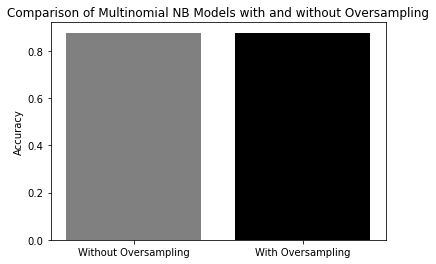

In [46]:
accuracy_no_oversampling = accuracy_score(y_test, y_test_pred_nb)
accuracy_with_oversampling = accuracy_score(y_test, y_test_pred_nb2)

# Create a bar chart for comparison
labels = ['Without Oversampling', 'With Oversampling']
accuracies = [accuracy_no_oversampling, accuracy_with_oversampling]

plt.bar(labels, accuracies, color=['grey', 'black'])
plt.ylabel('Accuracy')
plt.title('Comparison of Multinomial NB Models with and without Oversampling')
plt.show()


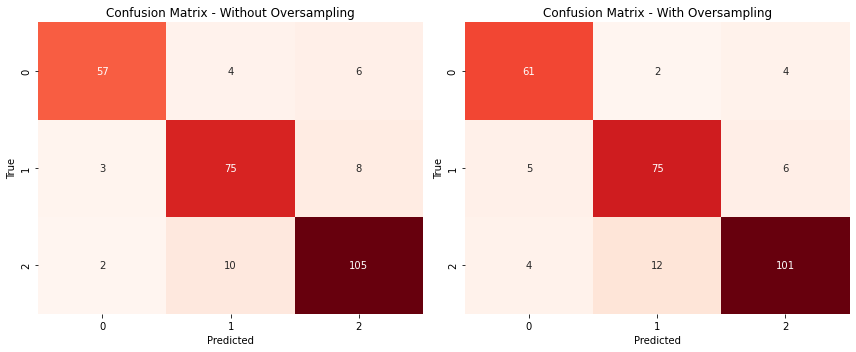

In [47]:
from sklearn.metrics import confusion_matrix


cm_no_oversampling = confusion_matrix(y_test, y_test_pred_nb)
cm_with_oversampling = confusion_matrix(y_test, y_test_pred_nb2)

# Plot confusion matrices in subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix without Oversampling
sns.heatmap(cm_no_oversampling, annot=True, fmt='d', cmap='Reds', cbar=False, ax=axs[0])
axs[0].set_title('Confusion Matrix - Without Oversampling')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

# Confusion Matrix with Oversampling
sns.heatmap(cm_with_oversampling, annot=True, fmt='d', cmap='Reds', cbar=False, ax=axs[1])
axs[1].set_title('Confusion Matrix - With Oversampling')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

## Random Forest 

### Without oversampling

In [48]:
param_grid = {
    'n_estimators': [50, 100, 80],
    'max_depth': [30, 10, 20],
    
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_tfidf, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_rf_model = grid_search.best_estimator_
y_train_pred = best_rf_model.predict(X_train_tfidf)

y_val_pred = best_rf_model.predict(X_val_tfidf)

y_test_pred = best_rf_model.predict(X_test_tfidf)

Best Hyperparameters: {'max_depth': 30, 'n_estimators': 50}


In [49]:
# Evaluate training performance
print("Training Performance:")
print(classification_report(y_train, y_train_pred))

# Evaluate validation performance
print("Validation Performance:")
print(classification_report(y_val, y_val_pred))

# Evaluate test performance
print("Test Performance:")
print(classification_report(y_test, y_test_pred))

# Compare training and test performance
print("Comparison between Training and Test Performance:")
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))



Training Performance:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       435
           1       1.00      0.87      0.93       524
           2       0.85      1.00      0.92       658

    accuracy                           0.93      1617
   macro avg       0.95      0.92      0.93      1617
weighted avg       0.94      0.93      0.93      1617

Validation Performance:
              precision    recall  f1-score   support

           0       0.96      0.65      0.78        75
           1       0.95      0.70      0.81        84
           2       0.69      0.98      0.81       110

    accuracy                           0.80       269
   macro avg       0.87      0.78      0.80       269
weighted avg       0.85      0.80      0.80       269

Test Performance:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79        67
           1       0.94      0.77      0.85        86
           

### With oversampling 

In [50]:
param_grid = {
    'n_estimators': [50, 100, 80],
    'max_depth': [30, 10, 20],
    
}

rf_classifier2 = RandomForestClassifier(random_state=1)

grid_search2 = GridSearchCV(estimator=rf_classifier2, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search2.fit(X_train_resampled, y_train_resampled)

best_params2 = grid_search2.best_params_
print("Best Hyperparameters:", best_params2)

best_rf_model2 = grid_search2.best_estimator_
y_train_pred2 = best_rf_model2.predict(X_train_tfidf)

y_val_pred2 = best_rf_model2.predict(X_val_tfidf)

y_test_pred2 = best_rf_model2.predict(X_test_tfidf)



Best Hyperparameters: {'max_depth': 30, 'n_estimators': 80}


In [51]:
print("Training Performance:")
print(classification_report(y_train, y_train_pred2))

print("Validation Performance:")
print(classification_report(y_val, y_val_pred2))

print("Test Performance:")
print(classification_report(y_test, y_test_pred2))

print("Comparison between Training and Test Performance:")
print("Training Accuracy:", accuracy_score(y_train, y_train_pred2))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred2))



Training Performance:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       435
           1       1.00      0.93      0.96       524
           2       0.93      1.00      0.96       658

    accuracy                           0.97      1617
   macro avg       0.97      0.96      0.97      1617
weighted avg       0.97      0.97      0.97      1617

Validation Performance:
              precision    recall  f1-score   support

           0       0.97      0.80      0.88        75
           1       0.92      0.79      0.85        84
           2       0.79      0.96      0.87       110

    accuracy                           0.86       269
   macro avg       0.89      0.85      0.86       269
weighted avg       0.88      0.86      0.86       269

Test Performance:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        67
           1       0.95      0.87      0.91        86
           

## Comparaison 

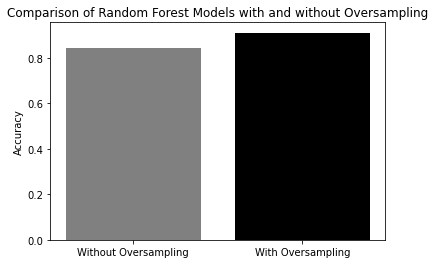

In [52]:
accuracy_no_oversampling_rf = accuracy_score(y_test, y_test_pred)
accuracy_with_oversampling_rf = accuracy_score(y_test, y_test_pred2)

# Create a bar chart for comparison
labels = ['Without Oversampling', 'With Oversampling']
accuracies = [accuracy_no_oversampling_rf, accuracy_with_oversampling_rf]

plt.bar(labels, accuracies, color=['grey', 'black'])
plt.ylabel('Accuracy')
plt.title('Comparison of Random Forest Models with and without Oversampling')
plt.show()



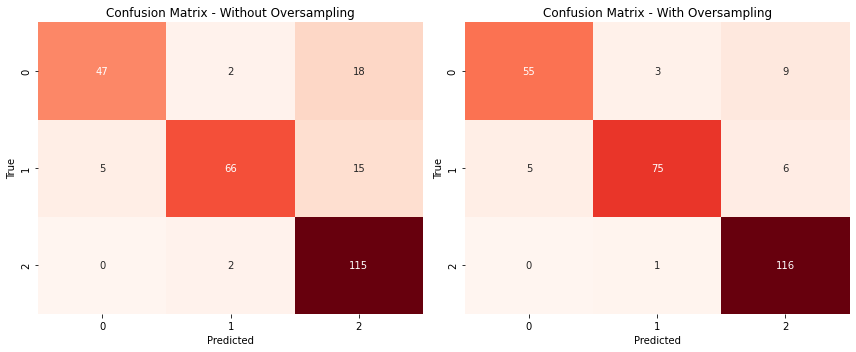

In [53]:
cm_no_oversampling2 = confusion_matrix(y_test, y_test_pred)
cm_with_oversampling2 = confusion_matrix(y_test, y_test_pred2)

# Plot confusion matrices in subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix without Oversampling
sns.heatmap(cm_no_oversampling2, annot=True, fmt='d', cmap='Reds', cbar=False, ax=axs[0])
axs[0].set_title('Confusion Matrix - Without Oversampling')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

# Confusion Matrix with Oversampling
sns.heatmap(cm_with_oversampling2, annot=True, fmt='d', cmap='Reds', cbar=False, ax=axs[1])
axs[1].set_title('Confusion Matrix - With Oversampling')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

## LSTM

In [54]:
train_data, test_data = train_test_split(dfp1, test_size=0.2, random_state=1)
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=1)
#convert our df to a tensorflowdataset 
def df_to_dataset(dataframe, shuffle=True, batch_size=8): #split dataset into smaller batches 
    df = dataframe.copy()
    labels = df.pop('category')
    ds = tf.data.Dataset.from_tensor_slices((df["title"], labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE) #data loading is done asynchronously while the model is training on the current batch.
    return ds

train_data = df_to_dataset(train_data)
valid_data = df_to_dataset(valid_data)
test_data = df_to_dataset(test_data)



In [55]:
encoder = tf.keras.layers.TextVectorization(max_tokens=1400)
encoder.adapt(train_data.map(lambda title, category: title))

vocab = np.array(encoder.get_vocabulary())
vocab[:200]


array(['', '[UNK]', 'gaza', 'israel', 'israeli', 'palestinian', 'hamas',
       'genocide', 'us', 'hostage', 'war', 'palestine', 'attack',
       'hospital', 'idf', 'journalist', 'people', 'child', 'home',
       'civilian', 'soldier', 'say', 'killed', 'netanyahu', 'west',
       'support', 'new', 'video', 'state', 'bombing', 'bomb', 'killing',
       'international', 'death', 'un', 'south', 'propaganda', 'one',
       'footage', 'family', 'day', 'bank', 'post', 'al', 'zionist',
       'news', 'kill', 'government', 'conflict', 'call', 'biden',
       'release', 'ceasefire', 'world', 'released', 'claim', 'opinion',
       'leader', 'want', 'show', 'crime', 'american', 'year', 'violence',
       'strip', 'settler', 'school', 'right', 'aid', 'woman', 'stop',
       'shot', 'military', 'case', 'uk', 'time', 'think', 'refugee',
       'occupation', 'take', 'message', 'jewish', 'iran', 'dead', 'would',
       'water', 'story', 'rape', 'minister', 'medium', 'live', 'force',
       'update', '

In [71]:
lstm_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1), #randomly drops out a fraction of the units during training to prevent overfitting
    tf.keras.layers.Dense(3, activation='softmax')
])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])




In [72]:
lstm_model.evaluate(train_data)
lstm_model.evaluate(valid_data)

44/44 [==============================] - 0s 7ms/step - loss: 1.0987 - accuracy: 0.3478


[1.0986933708190918, 0.3478260934352875]

In [73]:
history = lstm_model.fit(train_data, epochs=6, validation_data=valid_data)

Epoch 1/6
173/173 [==============================] - 12s 25ms/step - loss: 0.6761 - accuracy: 0.7273 - val_loss: 0.2570 - val_accuracy: 0.9304
Epoch 2/6
173/173 [==============================] - 4s 22ms/step - loss: 0.1202 - accuracy: 0.9630 - val_loss: 0.1747 - val_accuracy: 0.9420
Epoch 3/6
173/173 [==============================] - 3s 19ms/step - loss: 0.0552 - accuracy: 0.9840 - val_loss: 0.1255 - val_accuracy: 0.9652
Epoch 4/6
173/173 [==============================] - 3s 18ms/step - loss: 0.0096 - accuracy: 0.9971 - val_loss: 0.1259 - val_accuracy: 0.9594
Epoch 5/6
173/173 [==============================] - 3s 18ms/step - loss: 0.0252 - accuracy: 0.9942 - val_loss: 0.1086 - val_accuracy: 0.9739
Epoch 6/6
173/173 [==============================] - 4s 23ms/step - loss: 9.1407e-04 - accuracy: 1.0000 - val_loss: 0.1378 - val_accuracy: 0.9739


In [74]:
lstm_model.evaluate(test_data)

54/54 [==============================] - 0s 8ms/step - loss: 0.1319 - accuracy: 0.9699


[0.13190750777721405, 0.9699074029922485]

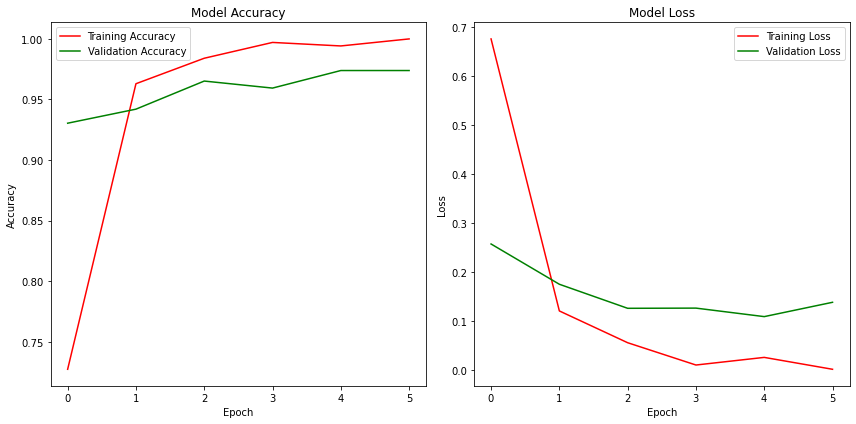

In [75]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy' , color = 'red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy' , color = 'green')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss' , color = 'red')
plt.plot(history.history['val_loss'], label='Validation Loss' , color = 'green')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Testing on new examples

In [77]:
# Save the model using TensorFlow SavedModel format
lstm_model.save("my_lstm_model", save_format='tf')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [3]:
# Load the model
loaded_lstm_model = load_model("my_lstm_model")

2024-02-06 16:55:16.628789: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2024-02-06 16:55:16.660081: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2024-02-06 16:55:17.016732: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2024-02-06 16:55:17.040378: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond' has 5 outputs but the _output_shapes attribute specifies shapes for 42 outputs. Output shapes may be inaccurate.
2024-02-06 16:55:17.183707: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'cond/while' has 13 outputs but the _output_sh

In [56]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# Function to preprocess a single title
def preprocess_title(text, words_to_keep_unchanged=None):
    if words_to_keep_unchanged is None:
        words_to_keep_unchanged = ["us" ]
    if isinstance(text, str):
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Tokenize the input text into words
        words = word_tokenize(text)
        # Remove stop words, make words lowercase, and apply lemmatization
        lemmatized_words = [
            word if word.lower() in words_to_keep_unchanged else lemmatizer.lemmatize(word.lower())
            for word in words
            if word.lower() not in stop_words and word.isalpha()
        ]
        lemmatized_text = ' '.join(lemmatized_words)
        return lemmatized_text
    else:
        return text



In [57]:
# Example user input function using the loaded model
def get_predictions(user_input, model):
    if isinstance(user_input, str):
        user_input = [user_input]  # Convert single title to a list for consistency

    # Preprocess user input
    preprocessed_titles = [preprocess_title(title) for title in user_input]

    # Tokenize and pad the preprocessed titles using the same encoder used during training
    encoded_user_input = encoder(preprocessed_titles).numpy()

    # Ensure that the input to the TextVectorization layer is a 1D array of strings
    encoded_user_input_1d = np.array(preprocessed_titles).reshape((-1, 1))

    # Make predictions
    predictions = model.predict(encoded_user_input_1d)

    # Assuming your model is a multi-class classification model
    predicted_labels = np.argmax(predictions, axis=1)

    # Return the predictions
    return predicted_labels

In [58]:
while True:
    user_title = input("Enter a title (type '0' to exit): \n ")

    if user_title == '0':
        print("Exiting the prediction loop.")
        break

    predictions = get_predictions(user_title, loaded_lstm_model)
    predicted_label = predictions[0]

    # Map predicted class to text label
    class_to_label_mapping = {
        0: "Media and Public Opinion",
        1: "Politics and Diplomacy",
        2: "Violence and Humanitarian Crisis"
    }

    predicted_label_text = class_to_label_mapping.get(predicted_label, "Unknown")

    print(f"Predicted Class: {predicted_label}, Label: {predicted_label_text}")



Enter a title (type '0' to exit): 
 Israeli Embassy in South Korea posted a vid showing what would happen if Hamas attacked them on Christmas . The goal was to make people from East Asia understand the war . Needless to say , the diplomatic move failed . The SK Foreign Ministry condemned the actions and demanded the video be removed.
1/1 [==============================] - 2s 2s/step
Predicted Class: 0, Label: Media and Public Opinion
Enter a title (type '0' to exit): 
 0
Exiting the prediction loop.
